In [17]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import math

from scipy import signal
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
from math import pi

from shutil import copyfile
import os

from matplotlib import rc

import scri
import gwsurrogate
#rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [18]:
## Load in the surrogate

sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

Loaded NRSur7dq4 model


## Functions for reading in waveforms, and ramp function for tapering

In [88]:
def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)

def ReadSurrogate(q, chiA, chiB, theta, mass = 68, distance = 400, dt=1/2048, inclination = pi):
    """ Read in an extrapolated SXS-format gravitational waveform mode, and 
        output the waveform in astrophysical units"""
    
    ## If we want to just do it with the inclination
    #t, h, dynamics = sur(q, chiA, chiB, dt = dt, units = 'mks', inclination = inclination, M = mass, dist_mpc = distance, f_low = 21)
    #h_plus = np.real(h)
    #h_cross = -1.0 * np.imag(h)
    
    ## If we want to do it ourselves
    modes = sur(q, chiA, chiB, dt = dt, units = 'mks', M = mass, dist_mpc = distance, f_low = 21, ellMax = 2)
    t = modes[0]
    
    h_plus = np.zeros(len(t))
    h_cross = np.zeros(len(t))
    
    #eval_modes = [[l,m] for l in range(2,9) for m in range(-l,l+1)]
    eval_modes = [[2,2], [2,-2]]
    for mode in eval_modes:
        
        l = mode[0]
        m = mode[1]
        data = modes[1][(l, m)]
        
        phi = 0
        Ylm = swsh(-2, [(l,m)], theta=inclination, phi=phi, psi=0) 
        
        coef = data
        h = coef * Ylm
 
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
    
    return t, h_plus, h_cross

def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    d_H1 = Detector("H1")
    d_L1 = Detector("L1")
    
    #The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay
    print(t_delay)
    
    return h_H1, h_L1, time_H1, time_L1
    

## Generate the frames files

In [71]:
## Simulation parameters -- hard-code the GW150914 NR simulation parameters for now. Future code will be more flexible and take in all of the relevant metadata
def ComputeChiEff(chi1, chi2, m1, m2):
    return (m1 * chi1[2] + m2 * chi2[2])/(m1 + m2)

adm_mass = 0.9917351317248174
q = 1.2212532137858916
mass = 68.0 
m2 = mass / (1 + q)
m1 = mass - m2
chirp_mass = (m1*m2)**(3.0/5.0)/(mass)**(1.0/5.0)
eta = (m1*m2)/(mass)**2
chi1 = np.array([0, 0, 0.33])
chi2 = np.array([0, 0, -0.44])
chi_eff = ComputeChiEff(chi1, chi2, m1, m2)
distance = 400 
print(m1, m2, chi_eff)

37.38665093292035 30.61334906707965 -0.016651158553696054


In [84]:
def GenerateFrames(rh_dir, theta, mass, distance, t_gps = 1126259462.4107006, peak_time_in_segment = 8.0, 
                   segment_length = 16.0, sample_rate = 2048, ra = 4.7614763656, 
                   dec=-0.531780006467, pol=0.310886773011):
    """ modes are the modes we wish to include 
        theta and phi are the angles of these modes to be put into the spherical harmonic functions 
        mass is the total mass of the system in solar masses
        distance is the distance to the system in megaparsecs """
    
    dt = 1 / sample_rate
    phi = 0.0
    
    ## Read in the data
    t, h_plus, h_cross = ReadSurrogate(q, chi1, chi1, theta)
    t = t - t[0]
    
    print(t)
    
    ramp = np.array([Ramp(time, 0.1, 0.3) for time in t])
    
    h_plus = h_plus * ramp
    h_cross = h_cross * ramp
    
    ## shift and pad the waveform before we do anything else
    t_peak = t[np.argmax(h_plus**2 + h_cross**2)]

    ## Parameters for shifting and padding the data
    shift_amount = (peak_time_in_segment - t_peak)
    start_pad = int(shift_amount * sample_rate)
    end_pad = int(sample_rate*segment_length - len(h_plus) - start_pad)
    segment_start = math.floor(t_gps) - int(peak_time_in_segment)

    h_plus = np.pad(h_plus, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
    h_cross = np.pad(h_cross, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
    t = np.arange(0., segment_length, dt) + t_gps - peak_time_in_segment
    
    strainH, strainL, timeH, timeL = ProjectToDetectors(ra=ra, dec=dec, pol=pol, \
                                                    t0=t_gps, plus=h_plus, cross=h_cross, time=t)
    
    ## Write the time series    
    out_dir = rh_dir + '/' + rh_dir.split('/')[-1] + '_mtotal_' + str(mass) + '_dist_' + str(distance)
    os.mkdir(out_dir)
    
    H1_padded = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
    L1_padded = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")
    H1_name = "H-H1_HOFT-" + str(segment_start) + \
                    "-" + str(int(segment_length)) + ".gwf"
    L1_name = "L-L1_HOFT-" + str(segment_start) + \
                    "-" + str(int(segment_length)) + ".gwf"
    H1_padded.write(out_dir + "/" + H1_name)
    L1_padded.write(out_dir + "/" + L1_name)

    ## Copy over the noise files
    copyfile('PSDs/design/aLIGOZeroDetHighPower-PSD.txt', out_dir + '/aLIGOZeroDetHighPower-PSD.txt')
    copyfile('PSDs/design/aLIGOZeroDetHighPower-PSD_25Hz.txt', out_dir + '/aLIGOZeroDetHighPower-PSD_25Hz.txt')
    
    ## Make the bayeswave cache files
    with open(out_dir + '/H1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + out_dir + '/' + H1_name + '\n')
    with open(out_dir + '/L1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + out_dir + '/' + L1_name + '\n')
        
    ## Copy over the bayewave ini files
    copyfile('run_bw.sh', out_dir + '/run_bw.sh')
    copyfile('dCS.ini', out_dir + '/dCS.ini')
    
    ## Make the metadata file
    with open(out_dir + '/Parameters.txt', 'a') as file:
        ## Temporarily hard-code the values for the GW150914 run
        file.write('dCS parameter value: 0.0' + '\n')
        file.write('Initial ADM energy: ' + str(adm_mass) + '\n')
        file.write('Initial Orbital frequency [Code units]: 0.019337522744' + '\n')
        file.write('Initial Separation [Code units]: 13.0' + '\n')
        file.write('Initial Eccentricity: 8.94e-05' + '\n')
        file.write('Number of Orbits: 11.9180876311' + '\n')
        file.write('Simulation common Horizon time [code units]: 2547.00520838' + '\n')
        
        file.write('Sample rate: ' + str(sample_rate) + '\n')
        file.write('Mass Ratio: ' + str(q) + '\n')
        file.write('Remnant mass [code units]: 0.951971474722' + '\n')
        print(mass)
        file.write('Total mass [solar masses]: ' + str(mass) + '\n')
        file.write('Mass 1: ' + str(m1) + '\n')
        file.write('Mass 2: ' + str(m2) + '\n')
        file.write('Chirp mass: ' + str(chirp_mass) + '\n')
        file.write('Symmetric mass ratio: ' + str(eta) + '\n')
        file.write('Dimensionless Spin 1 [heavier BH]: ' + str(chi1) + '\n')
        file.write('Dimensionless Spin 2 [lighter BH]: ' + str(chi2) + '\n')
        file.write('Chi effective: ' + str(chi_eff) + '\n')
        file.write('Chi precessing: 0.0 \n')
        
        file.write('Distance [Mpc]: ' + str(distance) + '\n')
        file.write('Inclination [theta]: ' + str(theta) + '\n')
        file.write('Azimuthal angle [phi]: ' + str(phi) + '\n')
        file.write('Right ascention: ' + str(4.7614763656) + '\n')
        file.write('Declination: ' + str(-0.531780006467) + '\n')
        file.write('Polarization: ' + str(0.310886773011) + '\n')
        file.write('t_gps [sec]: ' + str(t_gps) + '\n')
        file.write('Peak time in segment [sec]: ' + str(peak_time_in_segment) + '\n')
        file.write('Segment length [sec]: ' + str(16.0) + '\n')


In [89]:
GenerateFrames('/home/maria.okounkova/BeyondGRAnalysis/Waveforms/Surrogate_22', pi, 68, 400)

[0.00000000e+00 4.88281250e-04 9.76562500e-04 ... 6.98242187e-01
 6.98730469e-01 6.99218750e-01]
0.005239059443450027
68


## Read in TimeSeries from frames file and plot

In [90]:
def PlotSeriesFromFile(file, plot_fft = False):
    """ """

    s1 = TimeSeries.read(source = file + 'H-H1_HOFT-1126259454-16.gwf', channel="H1:LDAS_STRAIN")
    t1 = s1.times
    t_peak = t1[np.argmax(np.absolute(s1))]
    s2 = TimeSeries.read(source = file + 'L-L1_HOFT-1126259454-16.gwf', channel="L1:LDAS_STRAIN")
    t2 = s2.times
    
    t_peak = t1[np.argmax(np.absolute(s1))]
    print("t_peak = ",t_peak)

    plt.figure(figsize=(14, 8))
    
    if plot_fft:
        fft1 = s1.fft()
        plt.plot(fft1.frequencies, np.abs(fft1.value), color='#461ced', lw=1.0, label='Hanford', )
        fft2 = s2.fft()
        plt.plot(fft2.frequencies, np.abs(fft2.value), color='#de1666', lw=1.0, label='Livingston')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('h')
        plt.xlim(0, 400)
        plt.yscale('log')
        plt.axvline(25, color='black', label='25 Hz')
        plt.legend()
        plt.ylim(1e-26, 1e-23)
    
    else:
        plt.plot(t1, s1, label='Hanford', color='#461ced', lw=1.0)
        plt.plot(t2, s2, label='Livingston', color='#de1666', lw=1.0)
        plt.xlabel('Time [sec]')
        plt.legend()
        plt.ylabel('h')
        tt = 1126259462.4107006
        plt.legend()
        plt.xlim(tt - 0.6, tt + 0.1)
        
    plt.tight_layout()
    plt.savefig('FrequencyDomainInjected.pdf')
    plt.show()
    

t_peak =  1126259462.4102123 s


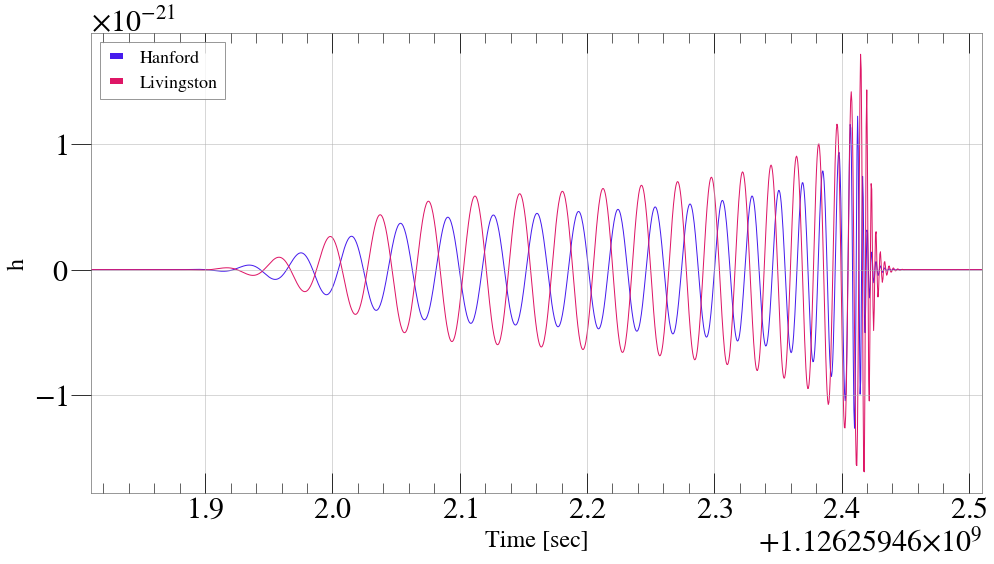

t_peak =  1126259462.4102123 s


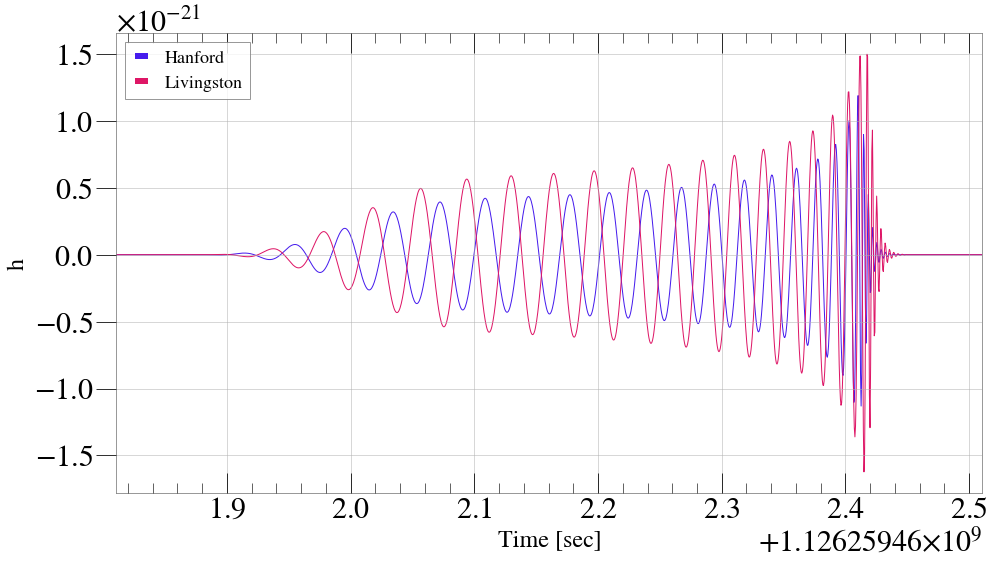

In [91]:
PlotSeriesFromFile("/home/maria.okounkova/BeyondGRAnalysis/Waveforms/Surrogate/Surrogate_mtotal_68_dist_400/", plot_fft = False)
PlotSeriesFromFile("/home/maria.okounkova/BeyondGRAnalysis/Waveforms/Surrogate_22/Surrogate_22_mtotal_68_dist_400/", plot_fft = False)
